In [1]:
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pyannote.core import Annotation, Segment
from typing import List, Dict
from scipy import signal
import matplotlib.pyplot as plt
from glob import glob
import soundfile as sf
import IPython.display as ipd
from pyannote.metrics.detection import DetectionErrorRate
import torch
from typing import Optional, Tuple


import warnings
warnings.filterwarnings("ignore")  

# Data

In [2]:
# Get audio files
print("Getting audio files...")
wave_pathes = glob(
    "../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/*/*.wav",
    recursive=True
)
wave_pathes = [wave_path.replace('\\', '/') for wave_path in wave_pathes]
print(f"Found {len(wave_pathes)} audio files")

Getting audio files...
Found 44242 audio files


In [3]:
sample_file = wave_pathes[0]
ipd.Audio(sample_file)

Consdiering that our dataset has very clean recording conditions, we can skip filtering step.

In general we can approach this task in the two following ways (considering that we dont use supervised learning here):
1. Threshold-based VAD
2. Clustering-based VAD

# Metric

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mtext>detection error rate</mtext>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <mtext>false alarm</mtext>
      <mo>+</mo>
      <mtext>missed detection</mtext>
    </mrow>
    <mtext>total</mtext>
  </mfrac>
</math>

where

**false alarm** is the duration of non-speech incorrectly classified as speech, 

**missed detection** is the duration of speech incorrectly classified as non-speech, 

**total** is the total duration of speech in the reference.



# RMS VAD

In [4]:
class SimpleVAD:
    def __init__(
        self,
        frame_length: int = 2048,
        hop_length: int = 512,
        energy_threshold_percentile: float = 30,  # Lowered from 95 to be more sensitive
        min_silence_duration: float = 0.2,
        min_speech_duration: float = 0.1  # Lowered to catch shorter speech segments
    ):
        """Initialize VAD system with configurable parameters.
        
        Args:
            frame_length: Length of each frame for feature extraction
            hop_length: Number of samples between frames
            energy_threshold_percentile: Percentile of energy to use as threshold
            min_silence_duration: Minimum silence duration in seconds
            min_speech_duration: Minimum speech duration in seconds
        """
        self.frame_length = frame_length
        self.hop_length = hop_length
        self.energy_threshold_percentile = energy_threshold_percentile
        self.min_silence_duration = min_silence_duration
        self.min_speech_duration = min_speech_duration

    def predict(self, y: np.ndarray, sr: int, plot_debug: bool = False) -> List[Dict[str, int]]:
        """Predict speech segments in audio signal using energy-based approach.
        
        Since VCTK has clean single-speaker recordings, we can use a simpler
        energy-based approach instead of clustering.
        """
        # Calculate frame energy
        rms = librosa.feature.rms(
            y=y, 
            frame_length=self.frame_length, 
            hop_length=self.hop_length
        )[0]
        
        # Use adaptive threshold based on energy distribution
        threshold = np.percentile(rms, self.energy_threshold_percentile)
        print(f"Energy threshold: {threshold:.6f}")
        print(f"Max energy: {np.max(rms):.6f}")
        print(f"Mean energy: {np.mean(rms):.6f}")
        
        # Get speech frames
        speech_frames = rms > threshold
        print(f"Number of frames above threshold: {np.sum(speech_frames)}")
        print(f"Total frames: {len(speech_frames)}")

        # Convert frames to timestamps
        timestamps = []
        in_speech = False
        speech_start = None
        
        for i, is_speech in enumerate(speech_frames):
            time = librosa.frames_to_time(i, sr=sr, hop_length=self.hop_length)
            
            if is_speech and not in_speech:
                speech_start = time
                in_speech = True
            elif not is_speech and in_speech:
                if time - speech_start >= self.min_speech_duration:
                    timestamps.append({
                        "start": int(speech_start * sr),
                        "end": int(time * sr)
                    })
                in_speech = False
        
        # Handle case where file ends during speech
        if in_speech:
            end_time = librosa.frames_to_time(
                len(speech_frames), sr=sr, hop_length=self.hop_length
            )
            if end_time - speech_start >= self.min_speech_duration:
                timestamps.append({
                    "start": int(speech_start * sr),
                    "end": int(end_time * sr)
                })
        
        # Merge segments that are too close
        merged = []
        for seg in timestamps:
            if not merged or \
               (seg["start"] - merged[-1]["end"])/sr >= self.min_silence_duration:
                merged.append(seg)
            else:
                merged[-1]["end"] = seg["end"]



        if plot_debug:
            # Plot the energy and threshold
            plt.figure(figsize=(15, 5))
            times = librosa.times_like(rms, sr=sr, hop_length=self.hop_length)
            plt.plot(times, rms, label='RMS Energy')
            plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
            plt.title('RMS Energy and Threshold')
            plt.xlabel('Time (s)')
            plt.ylabel('Energy')
            plt.legend()
            plt.show()
                
        return merged

    def create_annotation(self, timestamps: List[Dict[str, int]], sr: int) -> Annotation:
        """Convert timestamps to Annotation format for evaluation.
        
        Args:
            timestamps: List of dicts with start and end times
            sr: Sampling rate
            
        Returns:
            Pyannote Annotation object
        """
        reference = Annotation()
        for speech in timestamps:
            reference[Segment(
                speech["start"] / sr,
                speech["end"] / sr
            )] = "SPEECH"
        return reference

Processing file: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_232.wav
Audio loaded, duration: 3.16s
Energy threshold: 0.003156
Max energy: 0.174276
Mean energy: 0.036031
Number of frames above threshold: 208
Total frames: 297


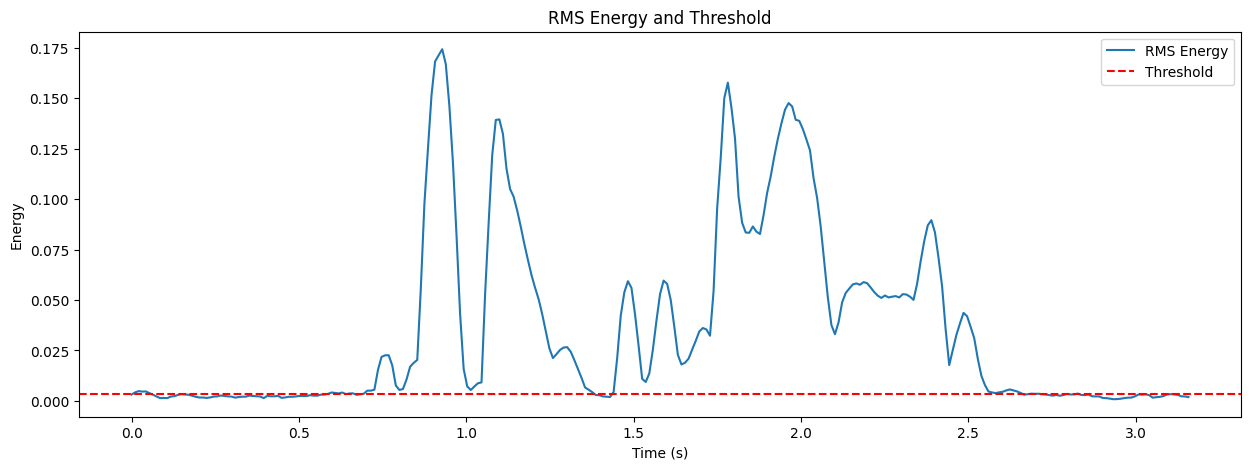


Detected speech segments:
Start: 0.68s, End: 2.67s


In [5]:
# Example audio file path
audio_path = wave_pathes[0]
print(f"Processing file: {audio_path}")

# Initialize VAD
vad = SimpleVAD()

# Load audio
y, sr = librosa.load(audio_path, sr=None)
print(f"Audio loaded, duration: {len(y)/sr:.2f}s")

# Get predictions with debug plot
timestamps = vad.predict(y, sr, plot_debug=True)

# Print results
print("\nDetected speech segments:")
if not timestamps:
    print("No speech segments detected!")
for segment in timestamps:
    print(f"Start: {segment['start']/sr:.2f}s, End: {segment['end']/sr:.2f}s")

Energy threshold selection 

# Clustering VAD

In [6]:
class ClusterVAD:
    def __init__(
        self,
        frame_length: int = 2048,    # Window size for feature extraction
        hop_length: int = 512,       # Step size between frames
        n_mfcc: int = 13,           # Number of MFCC coefficients
        n_clusters: int = 2,        # Number of clusters (speech/non-speech)
        min_silence_duration: float = 0.2,
        min_speech_duration: float = 0.1
    ):
        self.frame_length = frame_length
        self.hop_length = hop_length
        self.n_mfcc = n_mfcc
        self.n_clusters = n_clusters
        self.min_silence_duration = min_silence_duration
        self.min_speech_duration = min_speech_duration
        self.scaler = StandardScaler()
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    def extract_features(self, y: np.ndarray, sr: int) -> np.ndarray:
        """Extract multiple audio features for VAD"""
        
        # 1. Energy (RMS) - overall loudness
        rms = librosa.feature.rms(
            y=y, frame_length=self.frame_length, hop_length=self.hop_length
        )[0]
        
        # 2. Zero Crossing Rate - helps detect fricatives
        zcr = librosa.feature.zero_crossing_rate(
            y=y, frame_length=self.frame_length, hop_length=self.hop_length
        )[0]
        
        # 3. Spectral Centroid - brightness/timbre
        spectral_centroid = librosa.feature.spectral_centroid(
            y=y, sr=sr, n_fft=self.frame_length, hop_length=self.hop_length
        )[0]
        
        # 4. Spectral Bandwidth - spread of frequencies
        spectral_bandwidth = librosa.feature.spectral_bandwidth(
            y=y, sr=sr, n_fft=self.frame_length, hop_length=self.hop_length
        )[0]
        
        # 5. MFCCs - vocal tract configuration
        mfccs = librosa.feature.mfcc(
            y=y, sr=sr, n_mfcc=self.n_mfcc, 
            n_fft=self.frame_length, hop_length=self.hop_length
        )
        
        # 6. Delta MFCCs - temporal dynamics
        delta_mfccs = librosa.feature.delta(mfccs)
        
        # Combine all features
        features = np.vstack([
            rms,                    # Energy level (1)
            zcr,                    # Transient aspects (1)
            spectral_centroid,      # Spectral shape (1)
            spectral_bandwidth,     # Frequency spread (1)
            mfccs,                  # Spectral envelope (n_mfcc)
            delta_mfccs             # Temporal dynamics (n_mfcc)
        ])
        
        return features.T

    def predict(self, y: np.ndarray, sr: int, plot_debug: bool = False) -> List[Dict[str, int]]:
        """Predict speech segments using clustering approach"""
        
        # Extract features
        features = self.extract_features(y, sr)
        print(f"Feature matrix shape: {features.shape}")
        
        # Scale features
        features_scaled = self.scaler.fit_transform(features)
        
        # Perform clustering
        labels = self.kmeans.fit_predict(features_scaled)
        
        # Determine which cluster is speech (higher energy cluster)
        cluster_energies = [
            np.mean(features[:, 0][labels == i]) 
            for i in range(self.n_clusters)
        ]
        speech_cluster = np.argmax(cluster_energies)
        
        if plot_debug:
            # Plot features and clustering results
            plt.figure(figsize=(15, 10))
            
            # Plot RMS energy
            plt.subplot(311)
            times = librosa.times_like(features[:, 0], sr=sr, hop_length=self.hop_length)
            plt.plot(times, features[:, 0], label='RMS Energy')
            plt.title('Features and Clustering Results')
            plt.legend()
            
            # Plot cluster assignments
            plt.subplot(312)
            plt.plot(times, labels == speech_cluster, label='Speech Cluster')
            plt.legend()
            
            # Plot waveform
            plt.subplot(313)
            plt.plot(np.arange(len(y))/sr, y, label='Waveform')
            plt.legend()
            
            plt.tight_layout()
            plt.show()
        
        # Convert frame predictions to timestamps
        timestamps = []
        in_speech = False
        speech_start = None
        
        for i, is_speech in enumerate(labels == speech_cluster):
            time = librosa.frames_to_time(i, sr=sr, hop_length=self.hop_length)
            
            if is_speech and not in_speech:
                speech_start = time
                in_speech = True
            elif not is_speech and in_speech:
                if time - speech_start >= self.min_speech_duration:
                    timestamps.append({
                        "start": int(speech_start * sr),
                        "end": int(time * sr)
                    })
                in_speech = False
        
        # Handle case where file ends during speech
        if in_speech:
            end_time = librosa.frames_to_time(len(labels), sr=sr, hop_length=self.hop_length)
            if end_time - speech_start >= self.min_speech_duration:
                timestamps.append({
                    "start": int(speech_start * sr),
                    "end": int(end_time * sr)
                })
        
        # Merge segments that are too close
        merged = []
        for seg in timestamps:
            if not merged or \
               (seg["start"] - merged[-1]["end"])/sr >= self.min_silence_duration:
                merged.append(seg)
            else:
                merged[-1]["end"] = seg["end"]
                
        return merged

    def create_annotation(self, timestamps: List[Dict[str, int]], sr: int) -> Annotation:
        """Convert timestamps to Annotation format for evaluation"""
        reference = Annotation()
        for speech in timestamps:
            reference[Segment(
                speech["start"] / sr,
                speech["end"] / sr
            )] = "SPEECH"
        return reference

Processing file: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_232.wav
Audio loaded, duration: 3.16s
Feature matrix shape: (297, 30)


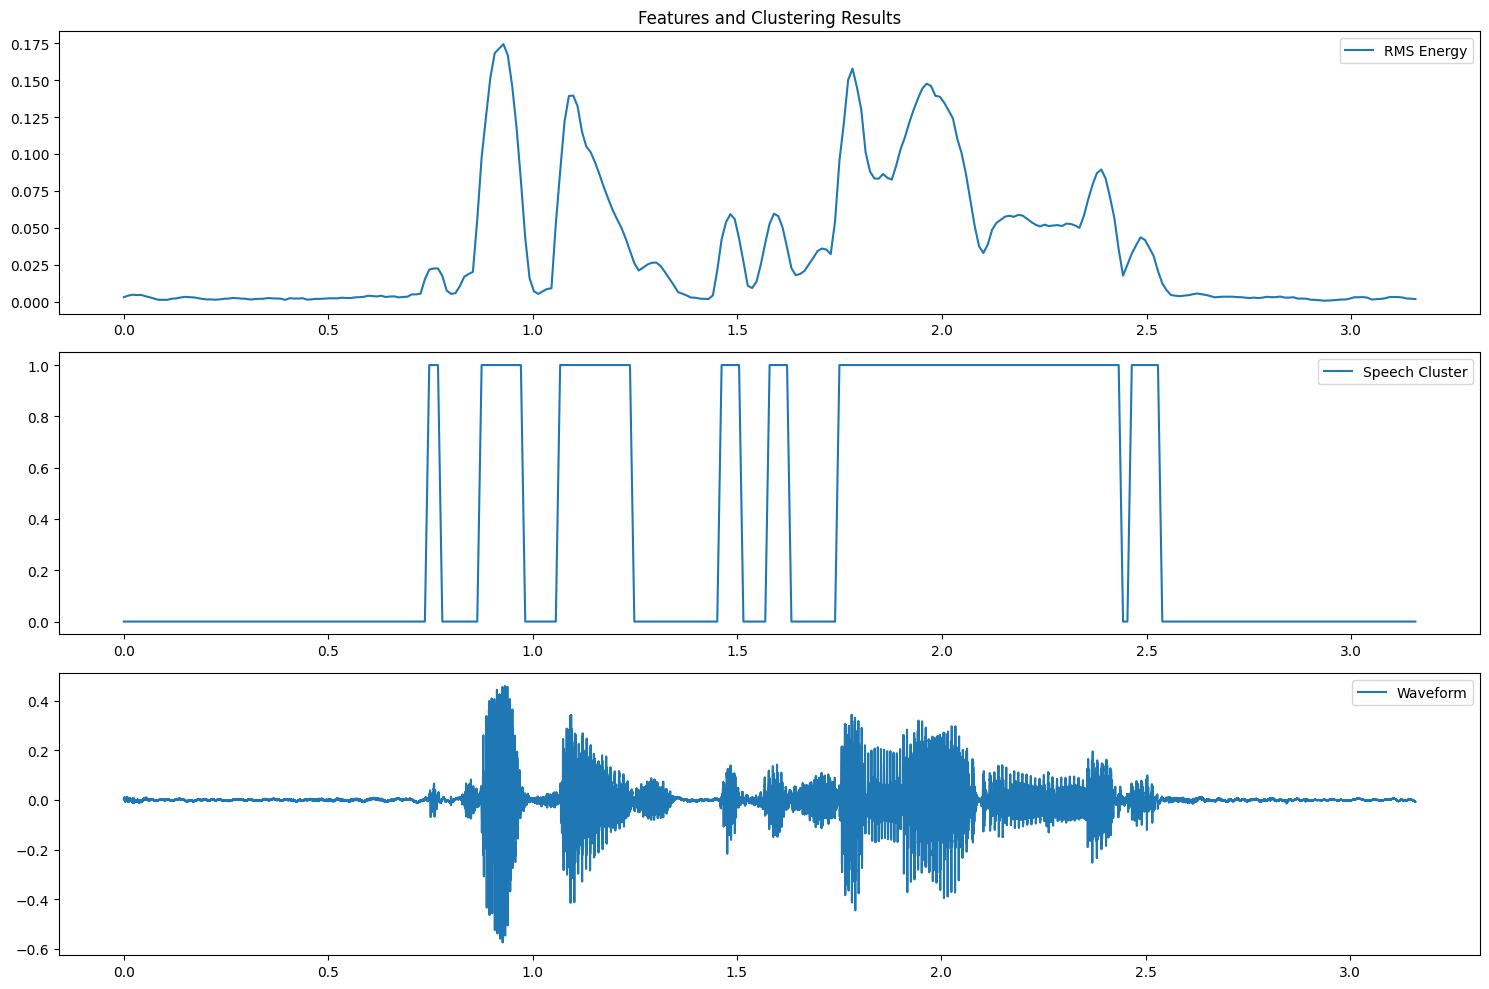


Detected speech segments:
Start: 0.87s, End: 1.25s
Start: 1.75s, End: 2.44s


In [7]:
# Example audio file path
audio_path = wave_pathes[0]
print(f"Processing file: {audio_path}")

# Initialize VAD
vad = ClusterVAD()

# Load audio
y, sr = librosa.load(audio_path, sr=None)
print(f"Audio loaded, duration: {len(y)/sr:.2f}s")

# Get predictions with debug plot
timestamps = vad.predict(y, sr, plot_debug=True)

# Print results
print("\nDetected speech segments:")
if not timestamps:
    print("No speech segments detected!")
for segment in timestamps:
    print(f"Start: {segment['start']/sr:.2f}s, End: {segment['end']/sr:.2f}s")

# Evaluation

In [8]:
def evaluate_vad(wave_paths, vad, get_speech_timestamps, read_audio, model, top_k=10, print_results=True):
    """Evaluate VAD performance against Silero VAD"""
    print("Starting evaluation...")
    metric = DetectionErrorRate()
    
    total_duration = 0
    total_our_segments = 0
    total_silero_segments = 0
    
    for file_idx, file in enumerate(wave_paths[:top_k]):
        try:
            print(f"\n{'='*50}")
            print(f"Processing file {file_idx + 1}: {file}")
            
            # Get Silero predictions (reference) - uses 16kHz
            wav = read_audio(file)  # Silero's read_audio resamples to 16kHz
            speech_timestamps = get_speech_timestamps(wav, model)
            
            # Get our VAD predictions - resample to match Silero
            audio_np, orig_sr = librosa.load(file, sr=None)
            audio_16k = librosa.resample(audio_np, orig_sr=orig_sr, target_sr=16000)
            
            if print_results:
                # Plot waveform and predictions
                plt.figure(figsize=(15, 8))
                
                # Plot waveform
                plt.subplot(211)
                times = np.arange(len(audio_16k)) / 16000
                plt.plot(times, audio_16k)
                plt.title('Waveform with VAD Predictions')
                plt.xlabel('Time (s)')
                
                # Plot Silero segments
                for speech in speech_timestamps:
                    plt.axvspan(speech["start"]/16000, speech["end"]/16000, 
                            color='green', alpha=0.2, label='Silero VAD')
                
                # Get and plot our predictions
                segments = vad.predict(audio_16k, sr=16000)
                for seg in segments:
                    plt.axvspan(seg["start"]/16000, seg["end"]/16000, 
                            color='red', alpha=0.2, label='Our VAD')
                
                plt.legend()
                plt.show()
            
            # Print predictions
            print("\nSilero VAD predictions:")
            for speech in speech_timestamps:
                print(f"Speech: {speech['start']/16000:.2f}s - {speech['end']/16000:.2f}s")
            
            print("\nOur VAD predictions:")
            for seg in segments:
                print(f"Speech: {seg['start']/16000:.2f}s - {seg['end']/16000:.2f}s")
            
            # Create annotations for evaluation
            reference = Annotation()
            for speech in speech_timestamps:
                reference[Segment(speech["start"]/16000, 
                                speech["end"]/16000)] = "SPEECH"
            
            hypothesis = vad.create_annotation(segments, sr=16000)
            
            # Calculate error for this file
            error = metric(reference, hypothesis)
            print(f"\nFile error rate: {abs(error) * 100:.1f}%")
            
            # Update statistics
            duration = len(audio_16k) / 16000
            total_duration += duration
            total_our_segments += len(segments)
            total_silero_segments += len(speech_timestamps)
            
            print(f"Audio duration: {duration:.2f}s")
            print(f"Our VAD segments: {len(segments)}")
            print(f"Silero segments: {len(speech_timestamps)}")
            
        except Exception as e:
            print(f"Error processing file {file}:")
            print(str(e))
            continue
    
    print(f"\nProcessing complete!")
    print(f"Total duration processed: {total_duration:.2f}s")
    print(f"Average our segments per file: {total_our_segments/10:.1f}")
    print(f"Average Silero segments per file: {total_silero_segments/10:.1f}")
    
    detection_error_rate = abs(metric)
    return detection_error_rate

In [9]:
# Load Silero VAD and unpack utilities
print("Loading Silero VAD...")
model, utils = torch.hub.load(
    repo_or_dir="snakers4/silero-vad",
    model="silero_vad",
    force_reload=True
)
get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks = utils
print("Silero VAD loaded")

Loading Silero VAD...


Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /Users/ivanbashtovyi/.cache/torch/hub/master.zip


Silero VAD loaded


## RMS-based VAD

Script started

Initializing our VAD...
Starting evaluation...

Processing file 1: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_232.wav
Energy threshold: 0.026531
Max energy: 0.133838
Mean energy: 0.039326
Number of frames above threshold: 49
Total frames: 99


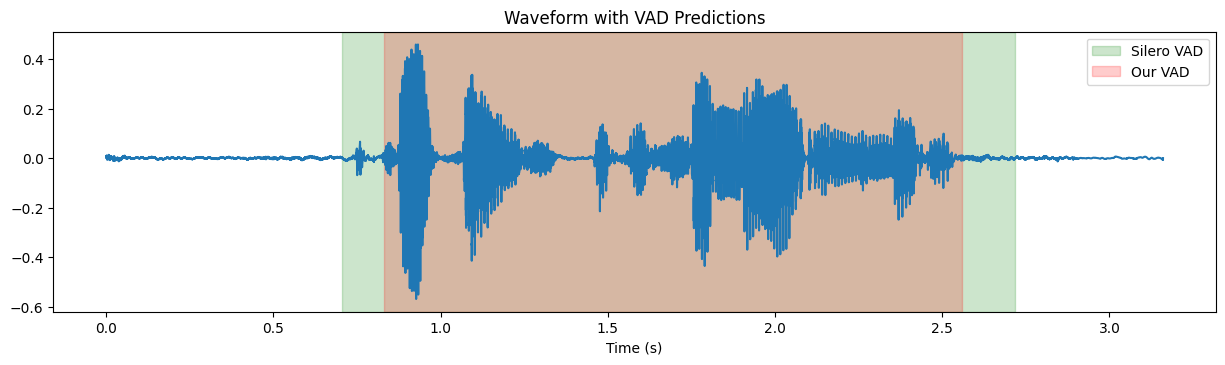


Silero VAD predictions:
Speech: 0.71s - 2.72s

Our VAD predictions:
Speech: 0.83s - 2.56s

File error rate: 14.1%
Audio duration: 3.16s
Our VAD segments: 1
Silero segments: 1

Processing file 2: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_226.wav
Energy threshold: 0.003494
Max energy: 0.127255
Mean energy: 0.026840
Number of frames above threshold: 49
Total frames: 99


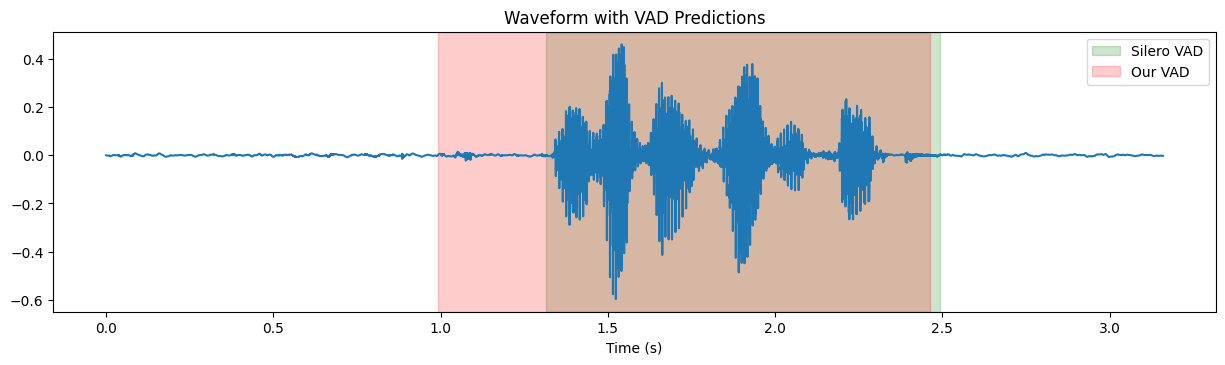


Silero VAD predictions:
Speech: 1.31s - 2.49s

Our VAD predictions:
Speech: 0.99s - 2.46s

File error rate: 29.8%
Audio duration: 3.16s
Our VAD segments: 1
Silero segments: 1

Processing file 3: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_018.wav
Energy threshold: 0.018575
Max energy: 0.221999
Mean energy: 0.037419
Number of frames above threshold: 116
Total frames: 233


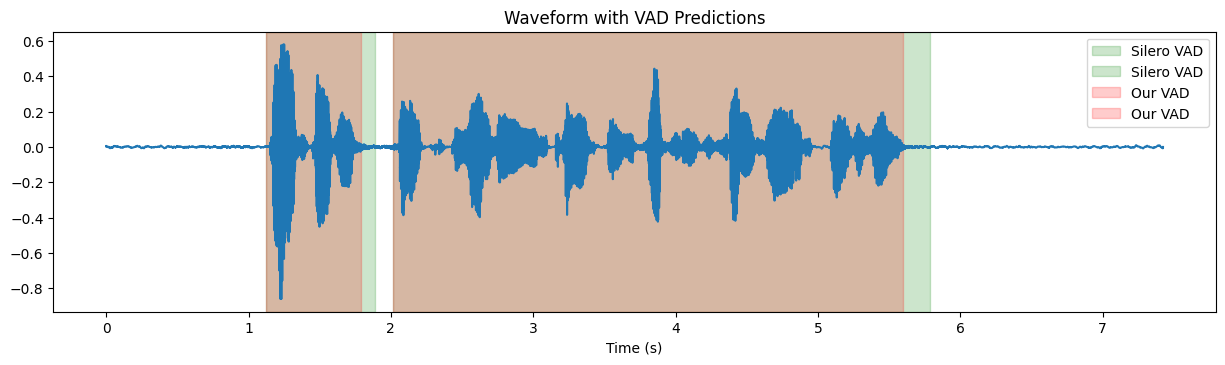


Silero VAD predictions:
Speech: 1.12s - 1.89s
Speech: 2.02s - 5.79s

Our VAD predictions:
Speech: 1.12s - 1.79s
Speech: 2.02s - 5.60s

File error rate: 6.3%
Audio duration: 7.42s
Our VAD segments: 2
Silero segments: 2

Processing file 4: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_030.wav
Energy threshold: 0.023391
Max energy: 0.198425
Mean energy: 0.037325
Number of frames above threshold: 53
Total frames: 107


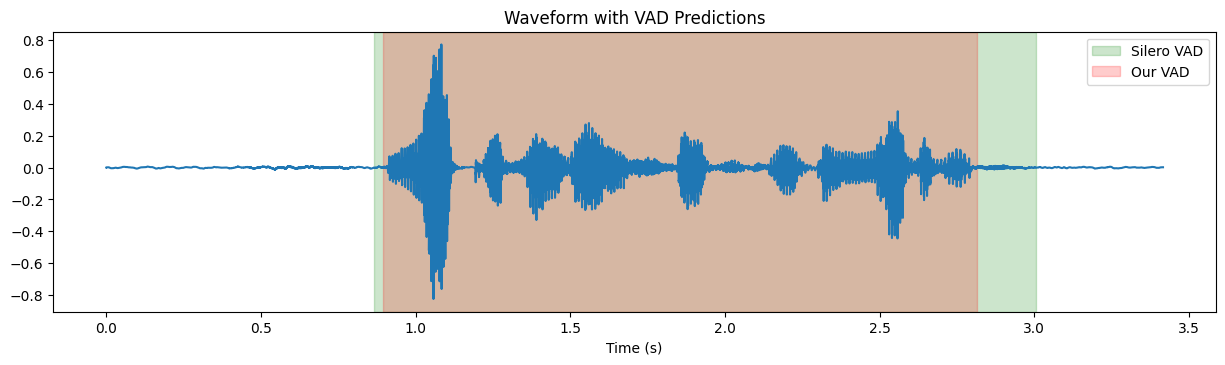


Silero VAD predictions:
Speech: 0.87s - 3.01s

Our VAD predictions:
Speech: 0.90s - 2.82s

File error rate: 10.3%
Audio duration: 3.42s
Our VAD segments: 1
Silero segments: 1

Processing file 5: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_024.wav
Energy threshold: 0.038482
Max energy: 0.195556
Mean energy: 0.043484
Number of frames above threshold: 126
Total frames: 253


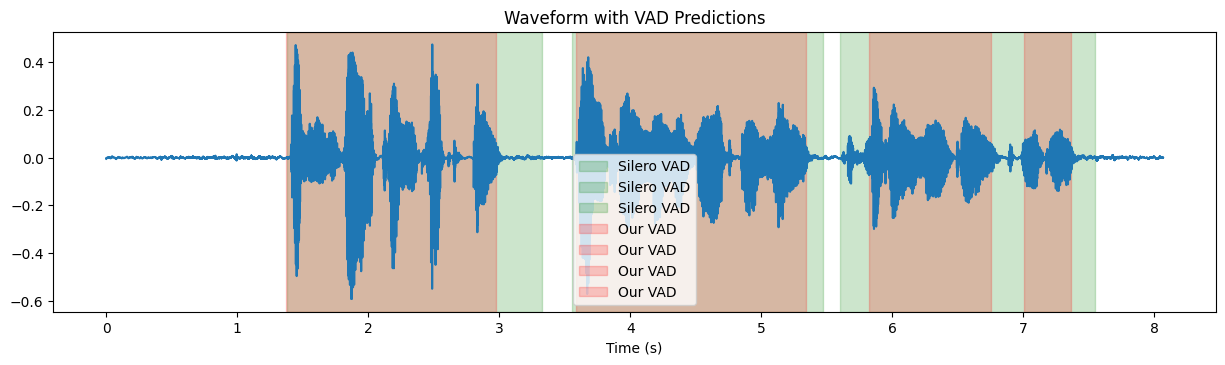


Silero VAD predictions:
Speech: 1.38s - 3.33s
Speech: 3.55s - 5.47s
Speech: 5.60s - 7.55s

Our VAD predictions:
Speech: 1.38s - 2.98s
Speech: 3.58s - 5.34s
Speech: 5.82s - 6.75s
Speech: 7.01s - 7.36s

File error rate: 20.2%
Audio duration: 8.07s
Our VAD segments: 4
Silero segments: 3

Processing file 6: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_187.wav
Energy threshold: 0.014544
Max energy: 0.160588
Mean energy: 0.038765
Number of frames above threshold: 43
Total frames: 87


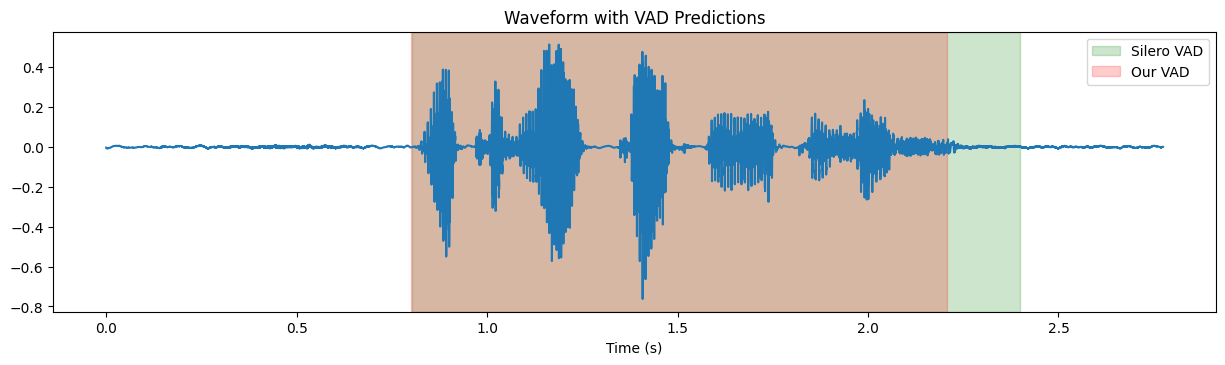


Silero VAD predictions:
Speech: 0.80s - 2.40s

Our VAD predictions:
Speech: 0.80s - 2.21s

File error rate: 12.0%
Audio duration: 2.77s
Our VAD segments: 1
Silero segments: 1

Processing file 7: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_193.wav
Energy threshold: 0.012225
Max energy: 0.232828
Mean energy: 0.047950
Number of frames above threshold: 50
Total frames: 101


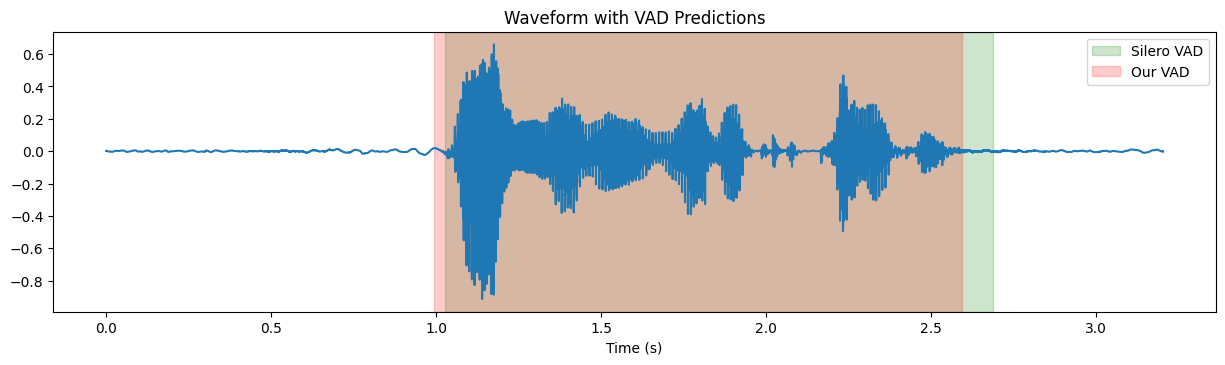


Silero VAD predictions:
Speech: 1.03s - 2.69s

Our VAD predictions:
Speech: 0.99s - 2.59s

File error rate: 7.7%
Audio duration: 3.20s
Our VAD segments: 1
Silero segments: 1

Processing file 8: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_178.wav
Energy threshold: 0.017787
Max energy: 0.119754
Mean energy: 0.025685
Number of frames above threshold: 63
Total frames: 126


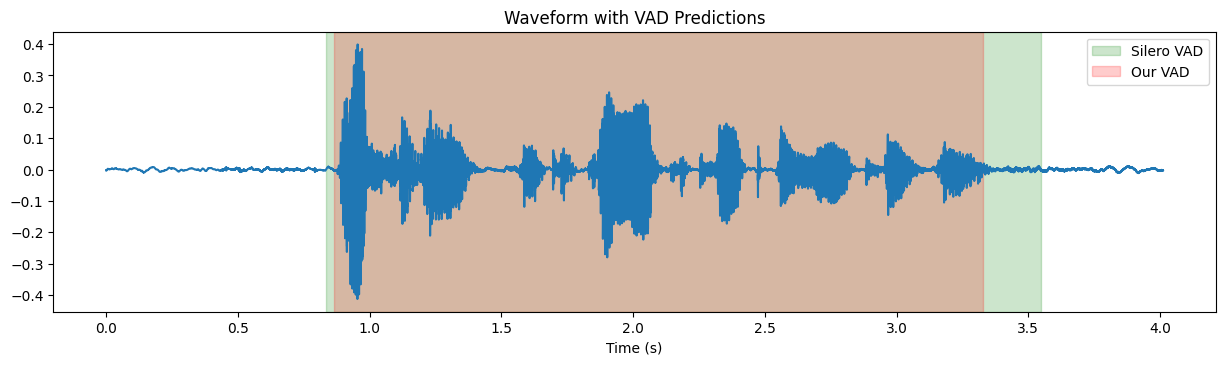


Silero VAD predictions:
Speech: 0.83s - 3.55s

Our VAD predictions:
Speech: 0.86s - 3.33s

File error rate: 9.3%
Audio duration: 4.01s
Our VAD segments: 1
Silero segments: 1

Processing file 9: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_144.wav
Energy threshold: 0.015809
Max energy: 0.120162
Mean energy: 0.027243
Number of frames above threshold: 58
Total frames: 117


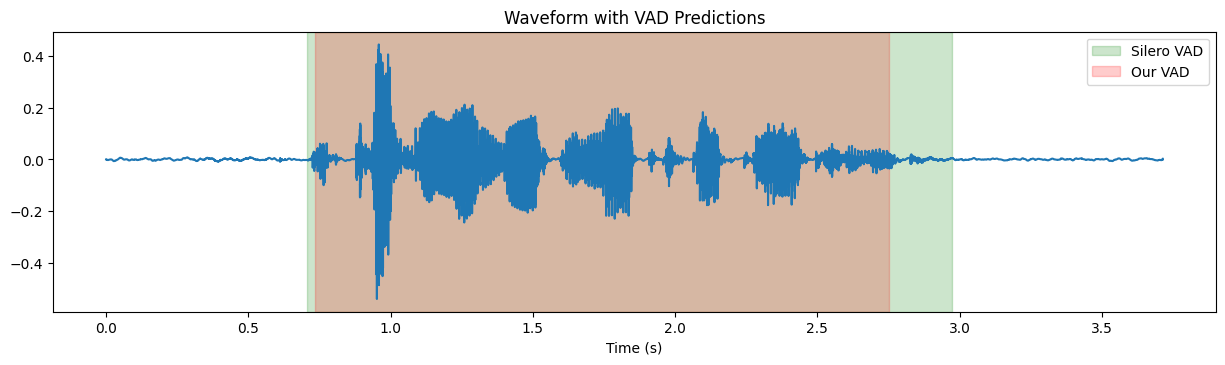


Silero VAD predictions:
Speech: 0.71s - 2.97s

Our VAD predictions:
Speech: 0.74s - 2.75s

File error rate: 11.1%
Audio duration: 3.71s
Our VAD segments: 1
Silero segments: 1

Processing file 10: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_150.wav
Energy threshold: 0.004599
Max energy: 0.101233
Mean energy: 0.018970
Number of frames above threshold: 49
Total frames: 98


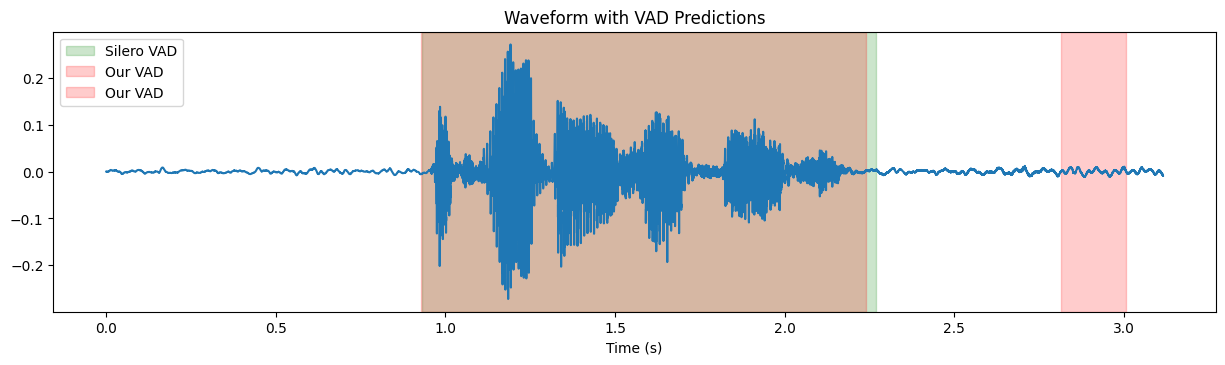


Silero VAD predictions:
Speech: 0.93s - 2.27s

Our VAD predictions:
Speech: 0.93s - 2.24s
Speech: 2.82s - 3.01s

File error rate: 16.7%
Audio duration: 3.12s
Our VAD segments: 2
Silero segments: 1

Processing complete!
Total duration processed: 42.05s
Average our segments per file: 1.5
Average Silero segments per file: 1.3

Overall detection error rate = 13.3%


In [10]:
print("Script started")

# Initialize RMS VAD
print("\nInitializing our VAD...")
vad = SimpleVAD(
    frame_length=2048,
    hop_length=512,
    energy_threshold_percentile=50,
    min_silence_duration=0.2,
    min_speech_duration=0.1
)

# Evaluate
error_rate = evaluate_vad(wave_pathes, vad, get_speech_timestamps, read_audio, model)
print(f'\nOverall detection error rate = {error_rate * 100:.1f}%')


## Clustering VAD

Script started
Starting evaluation...

Processing file 1: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_232.wav
Feature matrix shape: (99, 30)


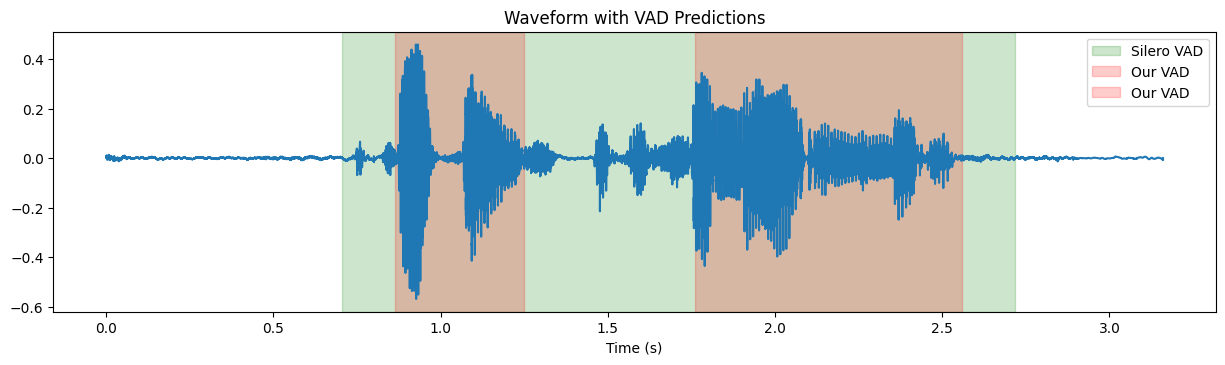


Silero VAD predictions:
Speech: 0.71s - 2.72s

Our VAD predictions:
Speech: 0.86s - 1.25s
Speech: 1.76s - 2.56s

File error rate: 41.2%
Audio duration: 3.16s
Our VAD segments: 2
Silero segments: 1

Processing file 2: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_226.wav
Feature matrix shape: (99, 30)


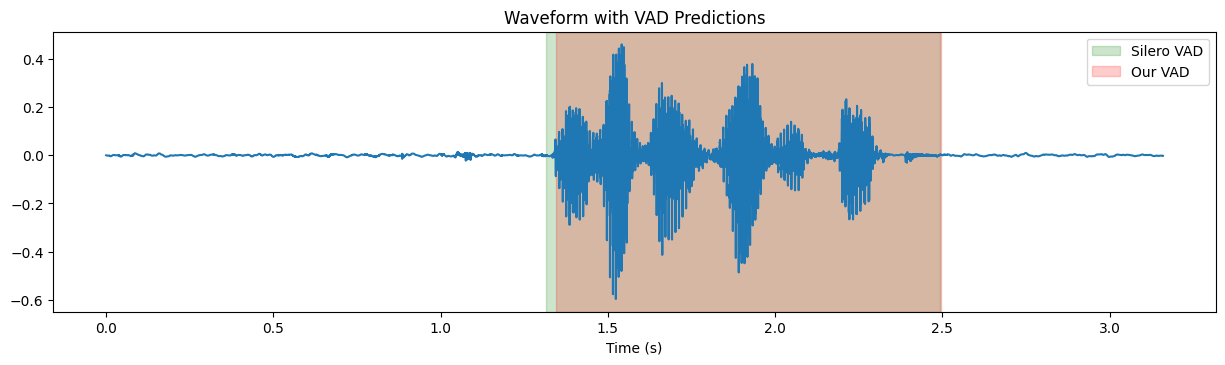


Silero VAD predictions:
Speech: 1.31s - 2.49s

Our VAD predictions:
Speech: 1.34s - 2.50s

File error rate: 2.7%
Audio duration: 3.16s
Our VAD segments: 1
Silero segments: 1

Processing file 3: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_018.wav
Feature matrix shape: (233, 30)


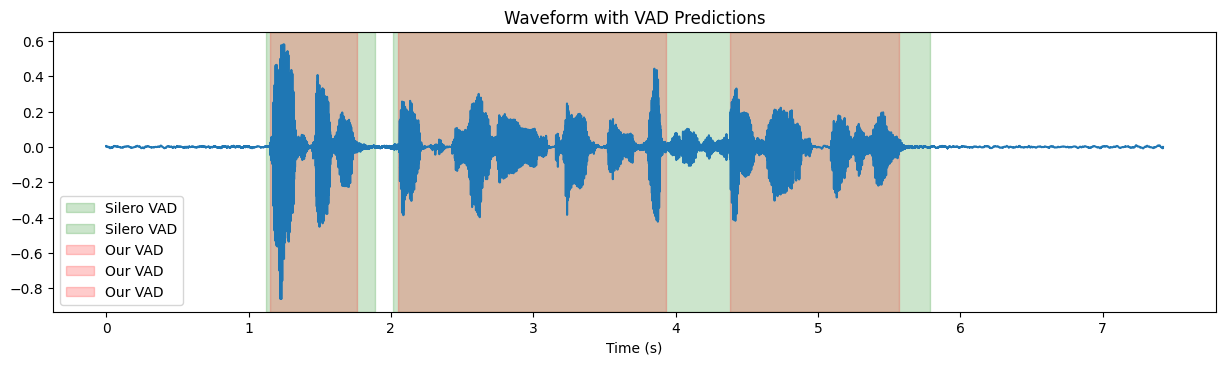


Silero VAD predictions:
Speech: 1.12s - 1.89s
Speech: 2.02s - 5.79s

Our VAD predictions:
Speech: 1.15s - 1.76s
Speech: 2.05s - 3.94s
Speech: 4.38s - 5.57s

File error rate: 18.9%
Audio duration: 7.42s
Our VAD segments: 3
Silero segments: 2

Processing file 4: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_030.wav
Feature matrix shape: (107, 30)


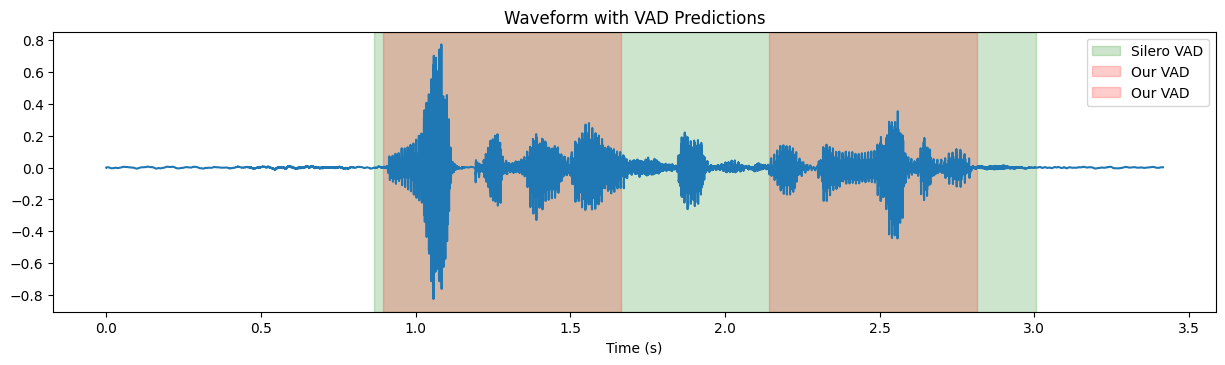


Silero VAD predictions:
Speech: 0.87s - 3.01s

Our VAD predictions:
Speech: 0.90s - 1.66s
Speech: 2.14s - 2.82s

File error rate: 32.7%
Audio duration: 3.42s
Our VAD segments: 2
Silero segments: 1

Processing file 5: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_024.wav
Feature matrix shape: (253, 30)


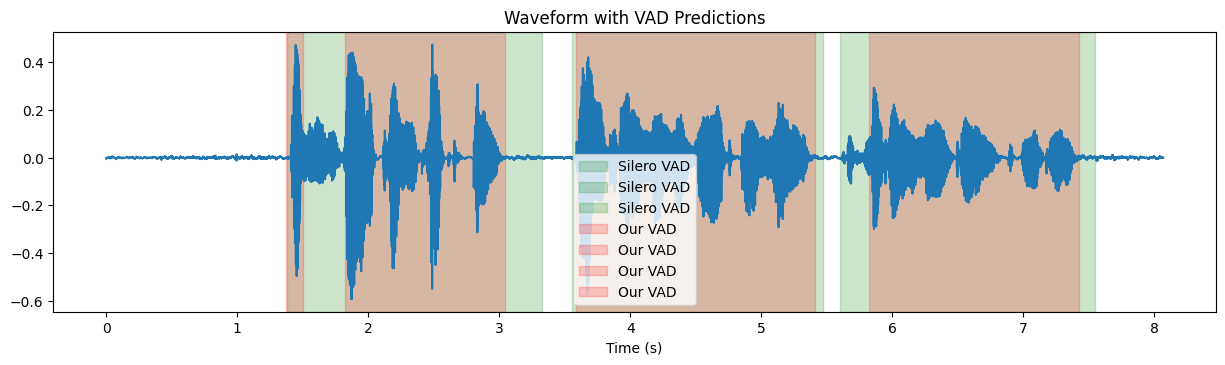


Silero VAD predictions:
Speech: 1.38s - 3.33s
Speech: 3.55s - 5.47s
Speech: 5.60s - 7.55s

Our VAD predictions:
Speech: 1.38s - 1.50s
Speech: 1.82s - 3.04s
Speech: 3.58s - 5.41s
Speech: 5.82s - 7.42s

File error rate: 18.0%
Audio duration: 8.07s
Our VAD segments: 4
Silero segments: 3

Processing file 6: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_187.wav
Feature matrix shape: (87, 30)


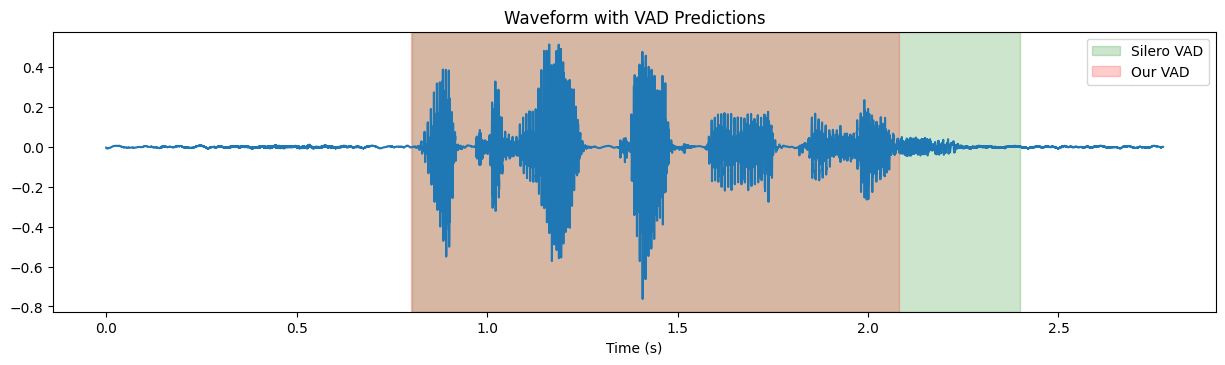


Silero VAD predictions:
Speech: 0.80s - 2.40s

Our VAD predictions:
Speech: 0.80s - 2.08s

File error rate: 20.1%
Audio duration: 2.77s
Our VAD segments: 1
Silero segments: 1

Processing file 7: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_193.wav
Feature matrix shape: (101, 30)


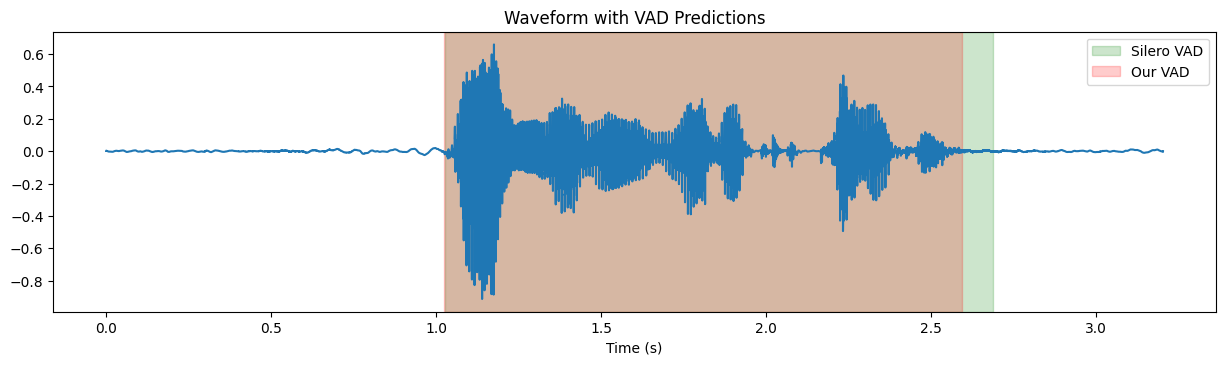


Silero VAD predictions:
Speech: 1.03s - 2.69s

Our VAD predictions:
Speech: 1.02s - 2.59s

File error rate: 5.8%
Audio duration: 3.20s
Our VAD segments: 1
Silero segments: 1

Processing file 8: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_178.wav
Feature matrix shape: (126, 30)


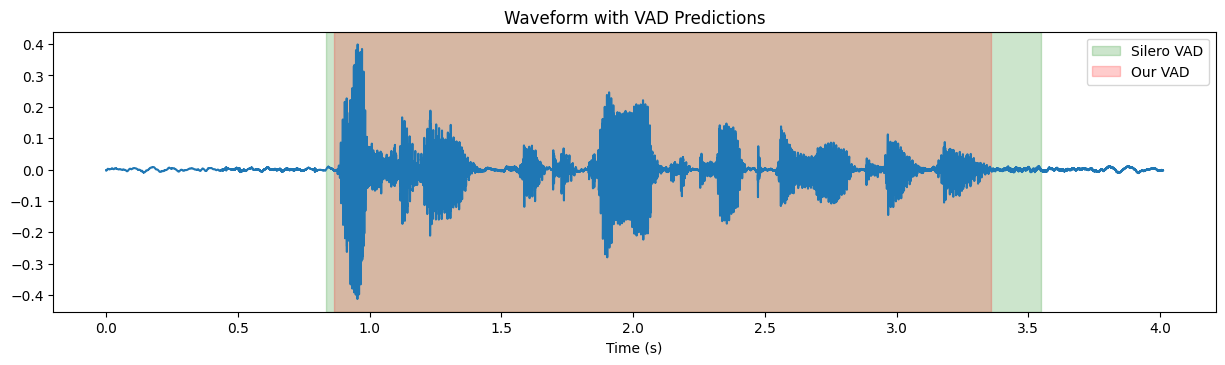


Silero VAD predictions:
Speech: 0.83s - 3.55s

Our VAD predictions:
Speech: 0.86s - 3.36s

File error rate: 8.1%
Audio duration: 4.01s
Our VAD segments: 1
Silero segments: 1

Processing file 9: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_144.wav
Feature matrix shape: (117, 30)


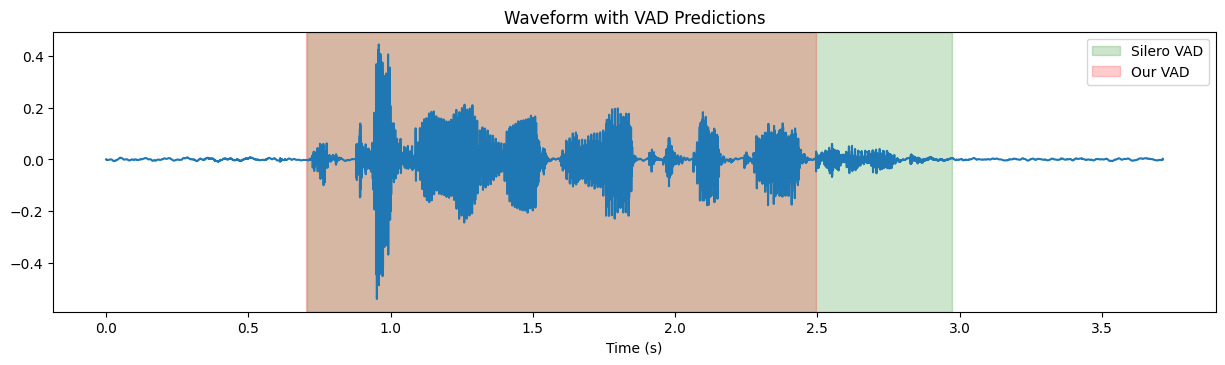


Silero VAD predictions:
Speech: 0.71s - 2.97s

Our VAD predictions:
Speech: 0.70s - 2.50s

File error rate: 21.2%
Audio duration: 3.71s
Our VAD segments: 1
Silero segments: 1

Processing file 10: ../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/p304/p304_150.wav
Feature matrix shape: (98, 30)


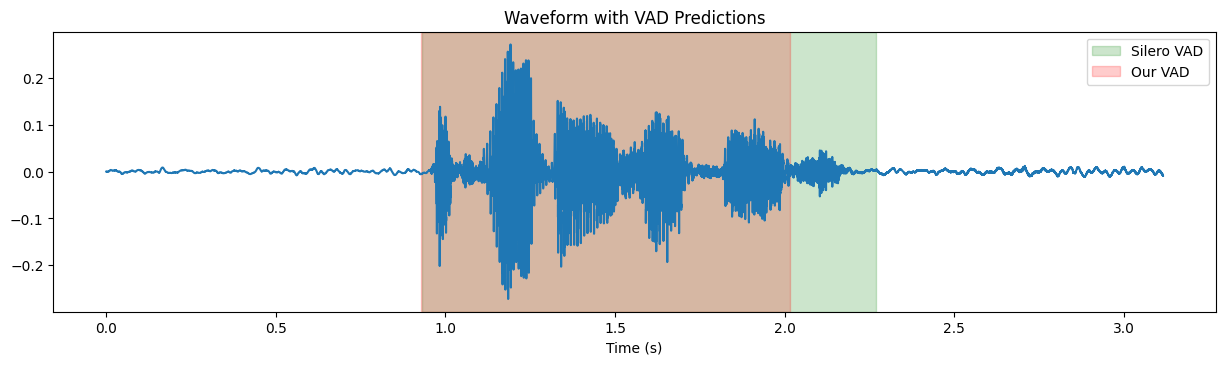


Silero VAD predictions:
Speech: 0.93s - 2.27s

Our VAD predictions:
Speech: 0.93s - 2.02s

File error rate: 19.1%
Audio duration: 3.12s
Our VAD segments: 1
Silero segments: 1

Processing complete!
Total duration processed: 42.05s
Average our segments per file: 1.7
Average Silero segments per file: 1.3
Cluster VAD error rate = 19.1%


In [11]:
print("Script started")

# Initialize Cluster VAD
cluster_vad = ClusterVAD(
    frame_length=2048,
    hop_length=512,
    n_mfcc=13,
    min_silence_duration=0.2,
    min_speech_duration=0.1
)

# Evaluate
cluster_error = evaluate_vad(wave_pathes, cluster_vad, get_speech_timestamps, read_audio, model)
print(f'Cluster VAD error rate = {cluster_error * 100:.1f}%')


## Evaluation showed that simple thresholding approach shows better results than clustering approach.

### Thresholding - 13.3%
### Clustering - 19.1%

# Conclusions

### RMS thresholding is all you need.